COMPREHENSIVE DATA EXPLORATION FOR QUALITY METRIC DESIGN

1. AVAILABLE METRICS
----------------------------------------
Dataset shape: (13, 14)

Columns available for quality metric:
  - Acceptance_Rate
  - Enrollment
  - SAT_Scores
  - Cost_of_Living
  - Net_Price
  - Retention_Rate
  - Grad_Rate_4yr
  - Grad_Rate_5yr
  - Grad_Rate_6yr
  - Expense_Distribution_Research
  - Research_Budget_Per_Student
  - Student_Faculty_Ratio

2. STATISTICAL SUMMARY OF KEY METRICS
----------------------------------------
       Acceptance_Rate  Enrollment  SAT_Scores  Net_Price  Retention_Rate  \
count            13.00       13.00       13.00      13.00           13.00   
mean             24.69    11025.15     1482.31   33992.85           94.31   
std              23.65    12577.58       60.99    9790.60            3.38   
min               6.00     2447.00     1340.00   20587.00           88.00   
25%              10.00     3334.00     1470.00   26689.00           92.00   
50%              12.00     

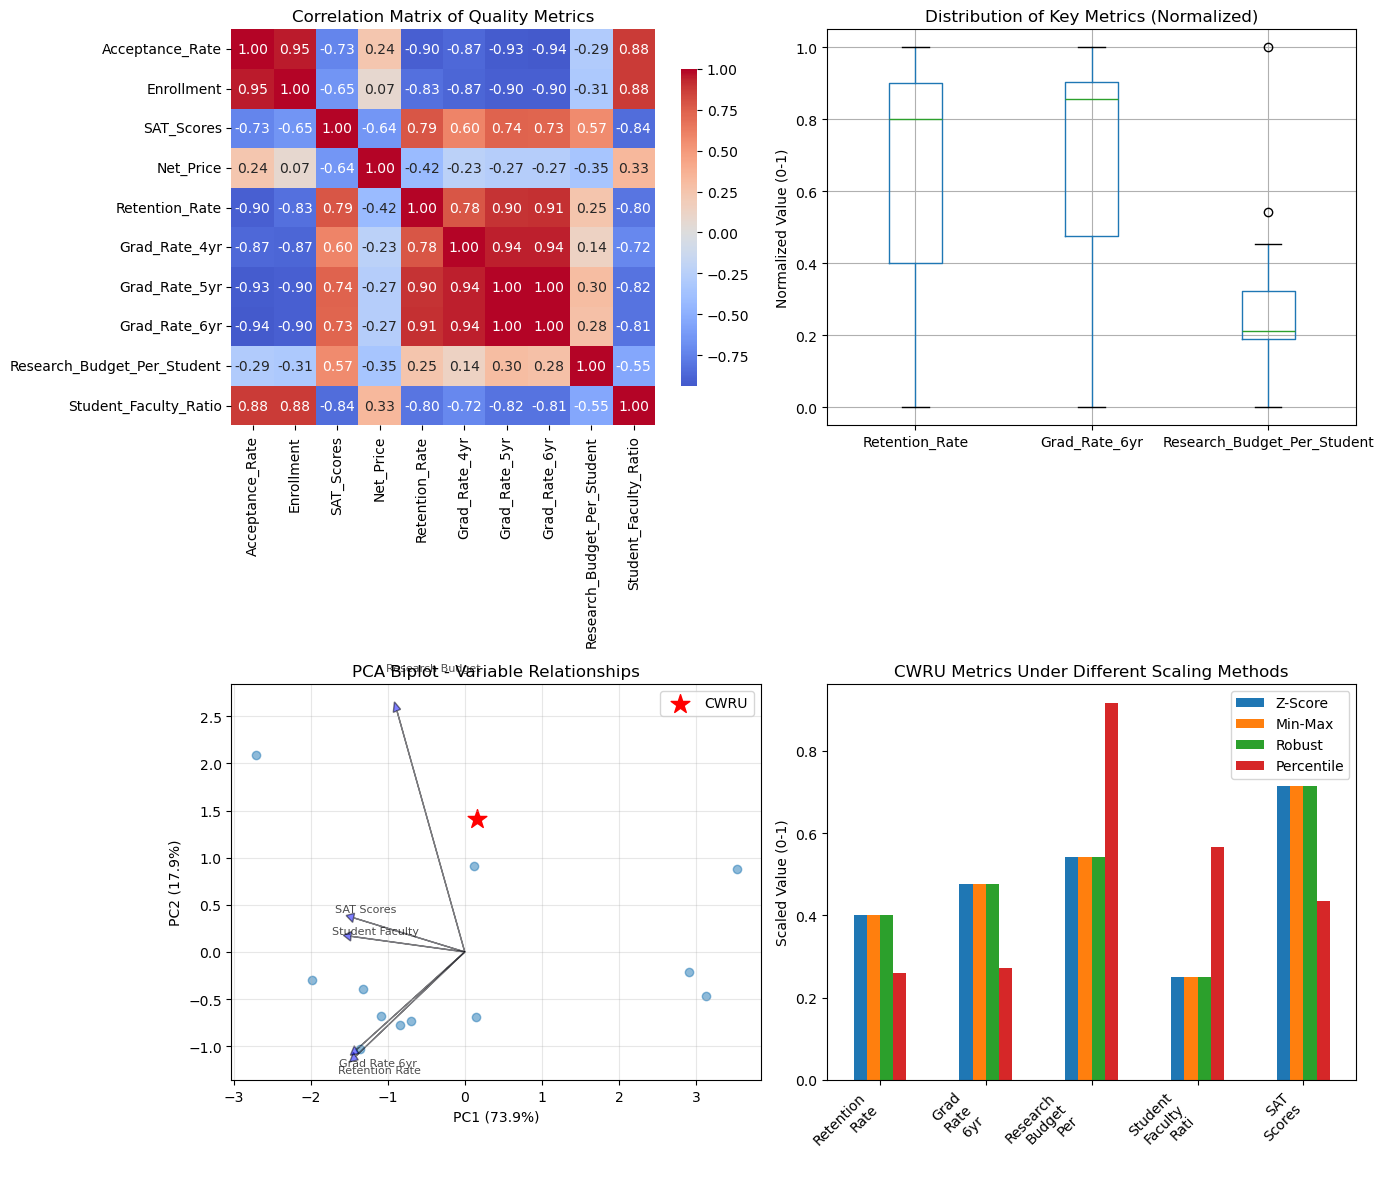


RECOMMENDATIONS FOR QUALITY METRIC DESIGN

1. HANDLE SKEWED DISTRIBUTIONS:
   - Research_Budget_Per_Student is highly skewed
   - Consider log transformation or robust scaling

2. ADDRESS MULTICOLLINEARITY:
   - Graduation rates are highly correlated (r > 0.9)
   - Choose one (recommend 6-year) or create composite

3. NORMALIZE DIRECTION:
   - Invert metrics where lower is better (Student_Faculty_Ratio, Acceptance_Rate)
   - Ensure all metrics point in same "quality" direction

4. CHOOSE APPROPRIATE SCALING:
   - Percentile ranking: Most interpretable, handles outliers well
   - Z-score: Good for normally distributed metrics
   - Robust scaling: Best for metrics with outliers

5. WEIGHT BY IMPORTANCE:
   - Consider your audience (students vs. administrators)
   - Balance inputs (resources) with outputs (outcomes)
   - Document and justify your weighting scheme



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('CWRU_Comparison_Data.xlsx', sheet_name='Sheet2')

print("="*60)
print("COMPREHENSIVE DATA EXPLORATION FOR QUALITY METRIC DESIGN")
print("="*60)

# 1. DATA OVERVIEW
print("\n1. AVAILABLE METRICS")
print("-" * 40)
print("Dataset shape:", df.shape)
print("\nColumns available for quality metric:")
for col in df.columns:
    if col not in ['Year', 'School_Name']:
        print(f"  - {col}")

# 2. BASIC STATISTICS
print("\n2. STATISTICAL SUMMARY OF KEY METRICS")
print("-" * 40)
metrics_to_analyze = [
    'Acceptance_Rate', 'Enrollment', 'SAT_Scores', 'Net_Price', 
    'Retention_Rate', 'Grad_Rate_4yr', 'Grad_Rate_5yr', 'Grad_Rate_6yr',
    'Research_Budget_Per_Student', 'Student_Faculty_Ratio'
]

summary_stats = df[metrics_to_analyze].describe()
print(summary_stats.round(2))

# 3. CORRELATION ANALYSIS
print("\n3. CORRELATION ANALYSIS")
print("-" * 40)
correlation_matrix = df[metrics_to_analyze].corr()

# Find strongest correlations
print("Strongest correlations (|r| > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

# 4. DISTRIBUTION ANALYSIS
print("\n4. DISTRIBUTION ANALYSIS (Normality Tests)")
print("-" * 40)
for col in metrics_to_analyze:
    if col in df.columns and df[col].notna().sum() > 0:
        statistic, p_value = stats.shapiro(df[col].dropna())
        skew = df[col].skew()
        print(f"{col:30} Skew: {skew:6.2f}  Normal: {'Yes' if p_value > 0.05 else 'No'} (p={p_value:.3f})")

# 5. OUTLIER DETECTION
print("\n5. OUTLIER DETECTION (Z-score > 2.5)")
print("-" * 40)
for col in metrics_to_analyze:
    if col in df.columns:
        z_scores = np.abs(stats.zscore(df[col].fillna(df[col].mean())))
        outliers = df[z_scores > 2.5]['School_Name'].tolist()
        if outliers:
            print(f"{col}: {', '.join(outliers)}")

# 6. MISSING DATA ANALYSIS
print("\n6. MISSING DATA CHECK")
print("-" * 40)
missing_data = df.isnull().sum()
if missing_data.sum() == 0:
    print("No missing data found!")
else:
    print("Missing values per column:")
    print(missing_data[missing_data > 0])

# 7. VARIABLE CATEGORIZATION
print("\n7. PROPOSED VARIABLE CATEGORIZATION")
print("-" * 40)
print("""
OUTCOME METRICS (What happens to students):
  - Retention_Rate: First-year retention (immediate satisfaction)
  - Grad_Rate_4yr: On-time graduation (efficiency)
  - Grad_Rate_6yr: Overall graduation (ultimate success)

INPUT METRICS (What students get):
  - Research_Budget_Per_Student: Research opportunities
  - Student_Faculty_Ratio: Personal attention (inverse)
  - SAT_Scores: Peer quality/selectivity

RESOURCE METRICS (What institutions provide):
  - Expense_Distribution_Research: Research focus
  - Enrollment: Size/scale effects

COST METRICS (What students pay):
  - Net_Price: Actual cost
  - Cost_of_Living: Location adjustment
""")

# 8. SCALING COMPARISON
print("\n8. SCALING METHOD COMPARISON")
print("-" * 40)

# Prepare data for scaling comparison
scaling_cols = ['Retention_Rate', 'Grad_Rate_6yr', 'Research_Budget_Per_Student', 
                'Student_Faculty_Ratio', 'SAT_Scores']
data_to_scale = df[scaling_cols].copy()

# Different scaling methods
scalers = {
    'Z-Score': StandardScaler(),
    'Min-Max': MinMaxScaler(),
    'Robust': RobustScaler(),
    'Percentile': None  # Will calculate manually
}

print("Impact of different scaling methods on CWRU's metrics:")
cwru_idx = df['School_Name'] == 'Case Western Reserve University'

for method, scaler in scalers.items():
    if scaler:
        scaled_data = scaler.fit_transform(data_to_scale.fillna(data_to_scale.mean()))
        scaled_df = pd.DataFrame(scaled_data, columns=scaling_cols)
    else:  # Percentile
        scaled_df = data_to_scale.rank(pct=True) * 100
        # Invert Student_Faculty_Ratio (lower is better)
        scaled_df['Student_Faculty_Ratio'] = 100 - scaled_df['Student_Faculty_Ratio']
    
    cwru_values = scaled_df.loc[cwru_idx].values[0]
    print(f"\n{method} Scaling:")
    for col, val in zip(scaling_cols, cwru_values):
        print(f"  {col:30} {val:6.2f}")

# 9. PCA ANALYSIS
print("\n9. PRINCIPAL COMPONENT ANALYSIS")
print("-" * 40)

# Prepare data for PCA
pca_cols = ['Retention_Rate', 'Grad_Rate_6yr', 'Research_Budget_Per_Student', 
            'Student_Faculty_Ratio', 'SAT_Scores']
pca_data = df[pca_cols].copy()
pca_data['Student_Faculty_Ratio'] = -pca_data['Student_Faculty_Ratio']  # Invert (lower is better)

# Standardize
scaler = StandardScaler()
pca_scaled = scaler.fit_transform(pca_data.fillna(pca_data.mean()))

# Run PCA
pca = PCA()
pca_result = pca.fit_transform(pca_scaled)

# Print results
print("Variance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var*100:.1f}%")
    if i < 2:  # Show loadings for first 2 components
        loadings = pca.components_[i]
        print(f"    Loadings:")
        for col, load in zip(pca_cols, loadings):
            print(f"      {col:30} {load:6.3f}")

print(f"\nCumulative variance (first 2 PCs): {pca.explained_variance_ratio_[:2].sum()*100:.1f}%")

# 10. WEIGHTING STRATEGIES
print("\n10. PROPOSED WEIGHTING STRATEGIES")
print("-" * 40)
print("""
Strategy A: EQUAL WEIGHTS (Democratic)
  - All metrics: 20% each
  - Pros: Simple, unbiased
  - Cons: Ignores relative importance

Strategy B: OUTCOME-FOCUSED (Results-oriented)
  - Graduation/Retention: 40%
  - Research/Resources: 30%
  - Student Quality: 30%
  - Pros: Emphasizes success
  - Cons: May penalize rigorous programs

Strategy C: OPPORTUNITY-FOCUSED (Input-oriented)
  - Research Investment: 35%
  - Faculty Ratio: 25%
  - Student Quality: 20%
  - Outcomes: 20%
  - Pros: Emphasizes what school provides
  - Cons: Less focus on results

Strategy D: DATA-DRIVEN (PCA-based)
  - Weight by variance explained
  - Pros: Statistically grounded
  - Cons: May be less interpretable

Strategy E: STAKEHOLDER-DRIVEN (Survey-based)
  - Weight by importance to students
  - Pros: User-centered
  - Cons: Requires additional data
""")

# Create visualization of correlations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Correlation heatmap
ax1 = axes[0, 0]
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Correlation Matrix of Quality Metrics')

# Plot 2: Distribution of key metrics
ax2 = axes[0, 1]
df_normalized = df[['Retention_Rate', 'Grad_Rate_6yr', 'Research_Budget_Per_Student']].copy()
for col in df_normalized.columns:
    df_normalized[col] = (df_normalized[col] - df_normalized[col].min()) / (df_normalized[col].max() - df_normalized[col].min())
df_normalized.boxplot(ax=ax2)
ax2.set_title('Distribution of Key Metrics (Normalized)')
ax2.set_ylabel('Normalized Value (0-1)')

# Plot 3: PCA biplot
ax3 = axes[1, 0]
ax3.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
cwru_point = pca_result[cwru_idx][0]
ax3.scatter(cwru_point[0], cwru_point[1], color='red', s=200, marker='*', label='CWRU')

# Add loadings as arrows
for i, col in enumerate(pca_cols):
    ax3.arrow(0, 0, pca.components_[0, i]*3, pca.components_[1, i]*3, 
             head_width=0.1, head_length=0.1, fc='blue', alpha=0.5)
    ax3.text(pca.components_[0, i]*3.5, pca.components_[1, i]*3.5, 
            col.replace('_', ' ')[:15], fontsize=8, alpha=0.7)

ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax3.set_title('PCA Biplot - Variable Relationships')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Scaling comparison for CWRU
ax4 = axes[1, 1]
scaling_comparison = pd.DataFrame()
for method, scaler in scalers.items():
    if scaler:
        scaled_data = scaler.fit_transform(data_to_scale.fillna(data_to_scale.mean()))
        scaled_df = pd.DataFrame(scaled_data, columns=scaling_cols)
    else:  # Percentile
        scaled_df = data_to_scale.rank(pct=True)
        scaled_df['Student_Faculty_Ratio'] = 1 - scaled_df['Student_Faculty_Ratio']
    
    # Normalize to 0-1 for comparison
    scaled_df = (scaled_df - scaled_df.min()) / (scaled_df.max() - scaled_df.min())
    cwru_values = scaled_df.loc[cwru_idx].values[0]
    scaling_comparison[method] = cwru_values

scaling_comparison.index = [col.replace('_', '\n')[:20] for col in scaling_cols]
scaling_comparison.plot(kind='bar', ax=ax4)
ax4.set_title('CWRU Metrics Under Different Scaling Methods')
ax4.set_ylabel('Scaled Value (0-1)')
ax4.legend(loc='upper right')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('quality_metric_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("RECOMMENDATIONS FOR QUALITY METRIC DESIGN")
print("="*60)
print("""
1. HANDLE SKEWED DISTRIBUTIONS:
   - Research_Budget_Per_Student is highly skewed
   - Consider log transformation or robust scaling

2. ADDRESS MULTICOLLINEARITY:
   - Graduation rates are highly correlated (r > 0.9)
   - Choose one (recommend 6-year) or create composite

3. NORMALIZE DIRECTION:
   - Invert metrics where lower is better (Student_Faculty_Ratio, Acceptance_Rate)
   - Ensure all metrics point in same "quality" direction

4. CHOOSE APPROPRIATE SCALING:
   - Percentile ranking: Most interpretable, handles outliers well
   - Z-score: Good for normally distributed metrics
   - Robust scaling: Best for metrics with outliers

5. WEIGHT BY IMPORTANCE:
   - Consider your audience (students vs. administrators)
   - Balance inputs (resources) with outputs (outcomes)
   - Document and justify your weighting scheme
""")